In [1]:
# import pandas library
import pandas as pd

# import pyplot for plotting graph
import matplotlib.pyplot as plt

# import library numpy which helps to manipulate data
import numpy as np

# import package to split the given data into training and testing set
from sklearn.model_selection import train_test_split

In [23]:
# read the csv file
dataset_init = pd.read_csv('Input_mag.csv', header=None)

dataset_init.rename(columns={0: 'input_1', 1: 'input_2', 2: 'output'}, inplace=True)
dataset_init.to_csv('Input_mag_processed.csv', index=False) # save to new csv file

dataset_fin = pd.read_csv('Input_mag_processed.csv', header=None)

# removed records with missing values
dataset_fin = dataset.dropna()



In [24]:
# print first ten records of the dataset
print("First ten records of the dataset:")
dataset_fin.head(10)

First ten records of the dataset:


input_1    input_2  output
0 -6.455430 -26.845491    0.01
1 -6.456265 -26.813642    0.02
2 -6.457106 -26.696892    0.03
3 -6.457953 -26.501795    0.04
4 -6.458807 -26.238475    0.05
5 -6.459667 -25.919039    0.06
6 -6.460534 -25.556042    0.07
7 -6.461407 -25.161299    0.08
8 -6.462287 -24.745173    0.09
9 -6.463173 -24.316274    0.10

Plot for each feature of the dataset:


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

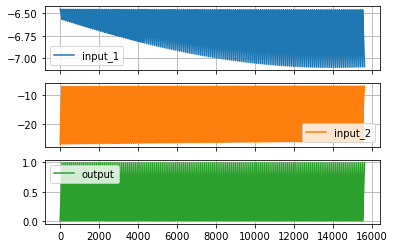

In [25]:
# plot each feature of the dataset on separate sub-plots
print("Plot for each feature of the dataset:")
dataset_fin.plot(subplots = True, grid = True)

In [27]:
# we have to predict the value of Gamma value so selected that column in Y
Y = dataset_fin['output']

# the othe remaining columns are selected in X
X = dataset_fin.loc[:,'input_1':'input_2']

In [28]:
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.3,random_state=2003)

# convert the values of training set to the numpy array
x_train_np = x_train.to_numpy()
y_train_np = y_train.to_numpy()

# convert the values of testing set to the numpy array
x_test_np = x_test.to_numpy()
y_test_np = y_test.to_numpy()

In [29]:
import torch

# import 1D convolutional layer
from torch.nn import Conv1d

# import max pooling layer
from torch.nn import MaxPool1d

# import the flatten layer 
from torch.nn import Flatten

# import linear layer
from torch.nn import Linear

# import activation function (ReLU)
from torch.nn.functional import relu

# import libraries required for working with dataset from pytorch
from torch.utils.data import DataLoader, TensorDataset

In [30]:
# defined model named as CnnRegressor and
# this model should be the subclass of torch.nn.Module 
class CnnRegressor(torch.nn.Module):
  # defined the initialization method
  def __init__(self, batch_size, inputs, outputs):
    # initialization of the superclass
    super(CnnRegressor, self).__init__()
    # store the parameters
    self.batch_size = batch_size
    self.inputs = inputs
    self.outputs = outputs
    # define the input layer
    self.input_layer = Conv1d(inputs, batch_size, 1, stride = 1)
   
    # define max pooling layer
    self.max_pooling_layer = MaxPool1d(1)

    # define other convolutional layers
    self.conv_layer1 = Conv1d(batch_size, 128, 1, stride = 3)
    self.conv_layer2 = Conv1d(128, 256, 1, stride = 3)
    self.conv_layer3 = Conv1d(256, 512, 1, stride = 3)

    # define the flatten layer
    self.flatten_layer = Flatten()

    # define the linear layer
    self.linear_layer = Linear(512, 128)

    # define the output layer
    self.output_layer = Linear(128, outputs)

  # define the method to feed the inputs to the model
  def feed(self, input):
    # input is reshaped to the 1D array and fed into the input layer
    input = input.reshape((self.batch_size, self.inputs, 1))

    # ReLU is applied on the output of input layer
    output = relu(self.input_layer(input))

    # max pooling is applied and then Convolutions are done with ReLU
    output = self.max_pooling_layer(output)
    output = relu(self.conv_layer1(output))

    output = self.max_pooling_layer(output)
    output = relu(self.conv_layer2(output))

    output = self.max_pooling_layer(output)
    output = relu(self.conv_layer3(output))

    # flatten layer is applied
    output = self.flatten_layer(output)

    # linear layer and ReLu is applied
    output = relu(self.linear_layer(output))

    # finally, output layer is applied
    output = self.output_layer(output)
    return output

In [31]:
# import SGD for optimizer
from torch.optim import SGD

# import Adam for optimizer
from torch.optim import Adam

# to measure the performance import L1Loss
from torch.nn import L1Loss

# install pytorch's ignite and then import R2 score package
!pip install pytorch-ignite
from ignite.contrib.metrics.regression.r2_score import R2Score

     |████████████████████████████████| 264 kB 1.3 MB/s eta 0:00:01


In [32]:
# define the batch size  
batch_size = 100
model = CnnRegressor(batch_size, X.shape[1], 1)

# we are using GPU so we have to set the model for that
model.cuda()

CnnRegressor(
  (input_layer): Conv1d(2, 100, kernel_size=(1,), stride=(1,))
  (max_pooling_layer): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv_layer1): Conv1d(100, 128, kernel_size=(1,), stride=(3,))
  (conv_layer2): Conv1d(128, 256, kernel_size=(1,), stride=(3,))
  (conv_layer3): Conv1d(256, 512, kernel_size=(1,), stride=(3,))
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (linear_layer): Linear(in_features=512, out_features=128, bias=True)
  (output_layer): Linear(in_features=128, out_features=1, bias=True)
)

In [33]:
# define the method for calculating average L1 Loss and R2 Score of given model
def model_loss(model, dataset, train = False, optimizer = None):
  # first calculated for the batches and at the end get the average
  performance = L1Loss()
  score_metric = R2Score()

  avg_loss = 0
  avg_score = 0
  count = 0

  for input, output in iter(dataset):
    # get predictions of the model for training set
    predictions = model.feed(input)

    # calculate loss of the model
    loss = performance(predictions, output)

    # compute the R2 score
    score_metric.update([predictions, output])
    score = score_metric.compute()

    if(train):
      # clear the errors
      optimizer.zero_grad()

      # compute the gradients for optimizer
      loss.backward()

      # use optimizer in order to update parameters
      # of the model based on gradients
      optimizer.step()

    # store the loss and update values
    avg_loss += loss.item()
    avg_score += score
    count += 1

  return avg_loss/count, avg_score/count

In [36]:
# define the number of epochs
epochs = 100

# define the performance measure and optimizer
# optimizer = SGD( model.parameters(), lr= 1e-5)
optimizer = Adam(model.parameters(), lr = 0.007)

# to process with GPU, training set is converted into torch variable
inputs = torch.from_numpy(x_train_np).cuda().float()
outputs = torch.from_numpy(y_train_np.reshape(y_train_np.shape[0],1)).cuda().float()

# create the DataLoader instance to work with batches
tensor = TensorDataset(inputs, outputs)
loader = DataLoader(tensor, batch_size, shuffle = True, drop_last = True)

# loop for number of epochs and calculate average loss
for epoch in range(epochs):
   # model is cycled through the batches
  avg_loss, avg_r2_score = model_loss(model, loader, train = True, optimizer = optimizer)
  print("Epoch " + str(epoch + 1) + ":\n\tLoss = " + str(avg_loss) + "\n\tR^2 Score = " + str(avg_r2_score))

torch.save(model.state_dict(),'Fereshteh_implementation.h')

Epoch 1:
	Loss = 0.019711623395528267
	R^2 Score = 0.9677253682937067
Epoch 2:
	Loss = 0.01521497938371853
	R^2 Score = 0.9946254960811101
Epoch 3:
	Loss = 0.01792664998510015
	R^2 Score = 0.994699377576716
Epoch 4:
	Loss = 0.014125532197227718
	R^2 Score = 0.9953962508046613
Epoch 5:
	Loss = 0.016398983981904633
	R^2 Score = 0.995084217569524
Epoch 6:
	Loss = 0.016688736266704328
	R^2 Score = 0.9956858420610504
Epoch 7:
	Loss = 0.012903601281481599
	R^2 Score = 0.9961380546004371
Epoch 8:
	Loss = 0.014841756014443866
	R^2 Score = 0.995295273791486
Epoch 9:
	Loss = 0.01522728186442491
	R^2 Score = 0.9954693704942393
Epoch 10:
	Loss = 0.014954514100874236
	R^2 Score = 0.9959858885075149
Epoch 11:
	Loss = 0.014074543243222827
	R^2 Score = 0.9962771947926579
Epoch 12:
	Loss = 0.01613911044775346
	R^2 Score = 0.9951328865670869
Epoch 13:
	Loss = 0.013526035267688813
	R^2 Score = 0.9958618232063469
Epoch 14:
	Loss = 0.013319593811527305
	R^2 Score = 0.9961681477763847
Epoch 15:
	Loss = 0.01

In [37]:
# to process with GPU, testing set is converted into torch variable
inputs = torch.from_numpy(x_test_np).cuda().float()
outputs = torch.from_numpy(y_test_np.reshape(y_test_np.shape[0],1)).cuda().float()

# create the DataLoader instance to work with batches
tensor = TensorDataset(inputs, outputs)
loader = DataLoader(tensor, batch_size, shuffle = True, drop_last = True)

# output of the performance of the model
avg_loss, avg_r2_score = model_loss(model, loader)
print("The model's L1 loss is: " + str(avg_loss))
print("The model's R^2 score is: " + str(avg_r2_score))

The model's L1 loss is: 0.009373964114195627
The model's R^2 score is: 0.997607493104072
